In [28]:
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor

%matplotlib notebook

In [219]:
main_path = r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-27_11-37-08_636397\processed"

In [220]:
trials=pd.read_csv(os.path.join(main_path,'trials_table.csv'))

In [221]:
trial_stim_dur=np.zeros(len(trials))
for tt in range(0,len(trials)):
    if trials['trial_sound_dur'].iloc[tt]>0:
        trial_stim_dur[tt]=trials['trial_sound_dur'].iloc[tt]
    elif trials['trial_vis_stim_dur'].iloc[tt]>0:
        trial_stim_dur[tt]=trials['trial_vis_stim_dur'].iloc[tt]

trials['trial_stim_dur']=trial_stim_dur

In [222]:
trials[:10]

,Unnamed: 0,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_rewarded,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,...,aud_false_alarm_trials,aud_miss_trials,aud_correct_reject_trials,aud_autoreward_trials,catch_trials,catch_resp_trials,trialStimStartFrame,stimStartTime,stimLatency,trial_stim_dur
0,0,0,sound1,sound1,True,True,1.0,0.00,False,False,...,False,False,False,False,False,False,549,1192.946301,0.038521,1.00
1,1,730,sound1,sound1,True,True,0.5,0.00,False,False,...,False,False,False,False,False,False,1056,1201.436226,0.071396,0.50
2,2,1237,sound1,sound1,True,True,1.0,0.00,False,False,...,False,False,False,False,False,False,1450,1208.006188,0.069208,1.00
3,3,1631,sound1,sound1,True,True,1.0,0.00,False,False,...,False,False,False,False,False,False,1738,1212.795970,0.055000,1.00
4,4,1919,sound1,sound1,True,True,0.5,0.00,False,False,...,False,False,False,False,False,False,2056,1218.106076,0.060146,0.50
5,5,2237,sound1,sound1,True,True,1.0,0.00,False,False,...,False,False,False,False,False,False,2339,1222.826038,0.059958,1.00
6,6,2520,sound2,sound1,True,False,1.0,0.00,False,False,...,True,False,False,False,False,False,2973,1233.394998,0.053437,1.00
7,7,3154,vis1,sound1,True,False,0.0,1.00,True,False,...,False,False,False,False,False,False,3446,1241.254115,0.022615,1.00
8,8,3627,catch,sound1,False,False,0.0,0.00,False,False,...,False,False,False,False,True,False,3794,1247.036430,0.000000,0.00
9,9,3975,vis1,sound1,False,False,0.0,0.75,True,False,...,False,False,False,False,False,False,4180,1253.497630,0.022530,0.75


In [223]:
lick_times=np.load(os.path.join(main_path,'lick_times.npy'),allow_pickle=True)
lick_times=lick_times[0]
# lick_times

In [224]:
units=pd.read_csv(os.path.join(main_path,'unit_table.csv'))

In [225]:
## fix this in processing code??
units=units.set_index('id')
# wf_dur=np.zeros((len(units)))
# for uu, uid in enumerate(units.index.values):
#     wf_dur[uu]=ast.literal_eval(units.loc[uid]['waveform_duration'])[0]
    
# units['waveform_duration']=wf_dur

In [23]:
# units

In [226]:
good_units=units.query('quality == "good" and \
                        isi_viol < 0.5 and \
                        amplitude_cutoff < 0.1 and \
                        presence_ratio > 0.95')

good_units=good_units.sort_values(by=['probe','peak_channel'])
# good_units

In [227]:
spike_times=np.load(os.path.join(main_path,'spike_times_aligned.npy'),allow_pickle=True).item()

In [25]:
# spike_times[good_units.index.values[0]]

In [228]:
frames=pd.read_csv(os.path.join(main_path,'frames_table.csv'))
# frames

In [229]:
#Make tensor
time_before_flash = 1
trial_duration = 3
bin_size = 0.02
trial_tensor = make_neuron_time_trials_tensor(good_units, spike_times, trials, 
                                              time_before_flash, trial_duration, 
                                              bin_size)

In [230]:
# make xarray
trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                       coords={
                           "unit_id": good_units.index.values,
                           "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                           "trials": trials.index.values
                           })

In [231]:
# rewarded trials
rew_trials = trials.query('trial_response == True and \
                           trial_rewarded == True and \
                           trialStimID == trialstimRewarded')

In [232]:
rew_trials

,Unnamed: 0,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_rewarded,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,...,aud_false_alarm_trials,aud_miss_trials,aud_correct_reject_trials,aud_autoreward_trials,catch_trials,catch_resp_trials,trialStimStartFrame,stimStartTime,stimLatency,trial_stim_dur
0,0,0,sound1,sound1,True,True,1.00,0.0,False,False,...,False,False,False,False,False,False,549,1192.946301,0.038521,1.00
1,1,730,sound1,sound1,True,True,0.50,0.0,False,False,...,False,False,False,False,False,False,1056,1201.436226,0.071396,0.50
2,2,1237,sound1,sound1,True,True,1.00,0.0,False,False,...,False,False,False,False,False,False,1450,1208.006188,0.069208,1.00
3,3,1631,sound1,sound1,True,True,1.00,0.0,False,False,...,False,False,False,False,False,False,1738,1212.795970,0.055000,1.00
4,4,1919,sound1,sound1,True,True,0.50,0.0,False,False,...,False,False,False,False,False,False,2056,1218.106076,0.060146,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,466,203646,sound1,sound1,True,True,1.00,0.0,False,False,...,False,False,False,False,False,False,203762,4595.224618,0.064208,1.00
467,467,203943,sound1,sound1,True,True,0.75,0.0,False,False,...,False,False,False,False,False,False,204033,4599.774742,0.060042,0.75
469,469,204760,sound1,sound1,True,True,0.75,0.0,False,False,...,False,False,False,False,False,False,204852,4613.504601,0.062271,0.75
470,470,205033,sound1,sound1,True,True,0.75,0.0,False,False,...,False,False,False,False,False,False,205175,4618.904403,0.057562,0.75


In [233]:
# unrewarded & response trials
nonrew_trials = trials.query('trial_response == True and \
                              trial_rewarded == False and \
                              trialStimID == trialstimRewarded')

In [234]:
nonrew_trials

,Unnamed: 0,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_rewarded,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,...,aud_false_alarm_trials,aud_miss_trials,aud_correct_reject_trials,aud_autoreward_trials,catch_trials,catch_resp_trials,trialStimStartFrame,stimStartTime,stimLatency,trial_stim_dur
25,25,11077,sound1,sound1,True,False,0.50,0.0,False,False,...,False,False,False,False,False,False,11171,1370.214638,0.058458,0.50
59,59,26588,sound1,sound1,True,False,1.00,0.0,False,False,...,False,False,False,False,False,False,26678,1629.502202,0.062292,1.00
79,79,34255,sound1,sound1,True,False,0.75,0.0,False,False,...,False,False,False,False,False,False,34387,1758.410865,0.063375,0.75
121,121,54990,sound1,sound1,True,False,0.75,0.0,False,False,...,False,False,False,False,False,False,55117,2105.047776,0.061646,0.75
185,185,85238,sound1,sound1,True,False,0.50,0.0,False,False,...,False,False,False,False,False,False,85729,2616.943033,0.065083,0.50
270,270,117894,sound1,sound1,True,False,0.75,0.0,False,False,...,False,False,False,False,False,False,118016,3158.077995,0.066375,0.75
273,273,118764,sound1,sound1,True,False,0.50,0.0,False,False,...,False,False,False,False,False,False,118870,3172.387860,0.064250,0.50
304,304,133438,sound1,sound1,True,False,0.50,0.0,False,False,...,False,False,False,False,False,False,133648,3420.075562,0.062042,0.50
308,308,134928,sound1,sound1,True,False,0.75,0.0,False,False,...,False,False,False,False,False,False,135050,3443.575348,0.058958,0.75
357,357,158689,sound1,sound1,True,False,0.50,0.0,False,False,...,False,False,False,False,False,False,158862,3842.681650,0.065500,0.50


In [235]:
trial_type_dict={}
trial_type_dict['rewarded']=rew_trials
trial_type_dict['nonrewarded']=nonrew_trials

<IPython.core.display.Javascript object>


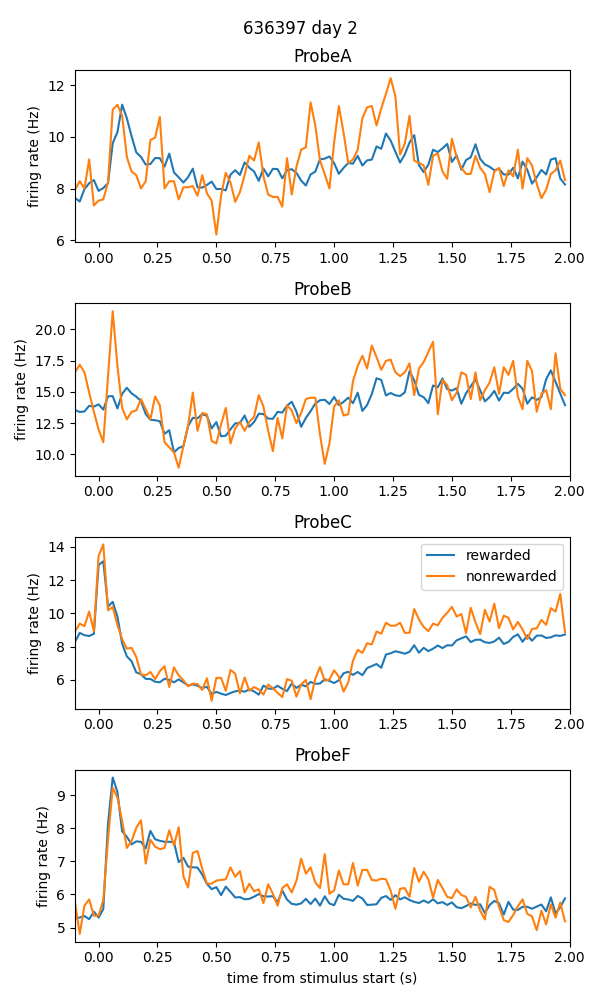

In [239]:
# plot population responses

trial_types = ['rewarded','nonrewarded']
probe_dict = ['A','B','C','F']

RS_units=good_units.query('waveform_duration >= 0.4')
FS_units=good_units.query('waveform_duration < 0.4')

unit_types=['RS','FS']

fig,ax=plt.subplots(len(probe_dict),1,figsize=(6,10))

for unit_type,sel_units in enumerate([good_units]):
    for ip,probe in enumerate(probe_dict):
        for trial_type in trial_types[:]:

            relevant_trials = trial_da.sel(trials=trial_type_dict[trial_type].index.values,
                                          unit_id=sel_units[sel_units['probe']==probe].index.values)

            # We can use 'mean' to conveniently average over units and trials
            mean_over_trials = relevant_trials.mean(dim=['unit_id', 'trials'])

            # Now plot.

            ax[ip].plot(trial_da.time, mean_over_trials)
        xlim = [-0.1, 2.0]

        ax[ip].set_ylabel('firing rate (Hz)')
        ax[ip].set_xlim(xlim)
        ax[ip].set_title('Probe'+probe)

    ax[-1].set_xlabel('time from stimulus start (s)')
    ax[2].legend(trial_type_dict)
    
fig.suptitle('636397 day 2')

fig.tight_layout()

In [237]:
## make probe-by-probe dicts - rewarded vs. non-rewarded

n_chans_to_average = 10
chan_vect = np.arange(0,384,n_chans_to_average)
# baseline_time = [-0.2,-0.06]
# stim_time = [0.06, 0.2]
baseline_time = [-0.75,-0.5]
stim_time = [1.5,1.75]

trial_types = ['rewarded','nonrewarded']
probe_dict = ['A','B','C','F']

#save [probe][trial_type] dicts of channel vectors?

line_styles = ['b-','b--','r-','r--','grey']
line_style = {}

channel_data={}
for pr in probe_dict:
    channel_data[pr]={}
    for it,tt in enumerate(trial_type_dict):
        channel_data[pr][tt]=np.zeros(len(chan_vect))
        line_style[tt]=line_styles[it]

for ip,probe in enumerate(probe_dict):
    for tt,trial_type in enumerate(trial_type_dict):
        for cc,ch in enumerate(chan_vect):
            #find units in channel range
            sel_units = good_units.query("peak_channel >= @ch and \
                                          peak_channel < @ch+@n_chans_to_average and \
                                          probe == @probe")
            unit_ch_idx = sel_units.index.values
            
            #find avg baseline fr of these units during these trials
            baseline_data = trial_da.sel(trials=trial_type_dict[trial_type].index.values,
                                         unit_id=unit_ch_idx,
                                         time=slice(baseline_time[0],baseline_time[1]))
            
            #find avg stim fr of these units during these trials
            stimulus_data = trial_da.sel(trials=trial_type_dict[trial_type].index.values,
                                         unit_id=unit_ch_idx,
                                         time=slice(stim_time[0],stim_time[1]))
            
            channel_data[probe][trial_type][cc]=np.abs(stimulus_data.mean()-baseline_data.mean())
            
    


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

<IPython.core.display.Javascript object>


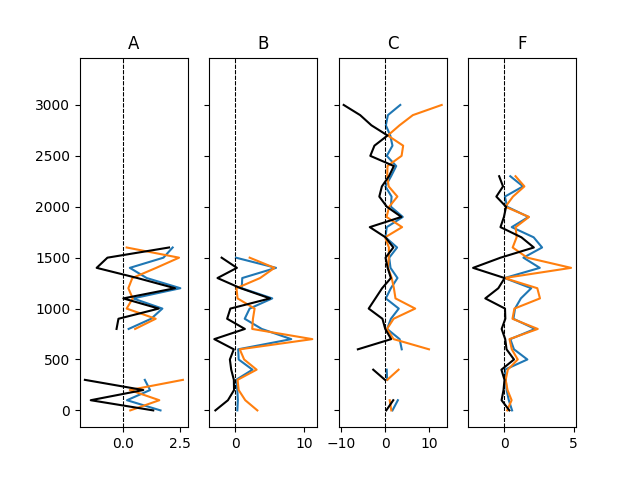

In [238]:
# plot the channel-wise data

fig, ax = plt.subplots(1,len(probe_dict),sharey=True)

for ip,probe in enumerate(probe_dict):
    for tt,trial_type in enumerate(trial_type_dict):
        ax[ip].axvline(0,linestyle='--',color='k',linewidth=0.75)
        ax[ip].plot(channel_data[probe][trial_type],chan_vect*10)
        
    ax[ip].plot((channel_data[probe]['rewarded']-channel_data[probe]['nonrewarded']),chan_vect*10,'k-')
#         if trial_type=='rewarded':
#             ax[ip].plot(-channel_data[probe][trial_type],chan_vect*10)
#         elif trial_type=='nonrewarded':
#             ax[ip].plot(channel_data[probe][trial_type],chan_vect*10)
            
#     if ip>0:
#         ax[ip].set_yticklabels([])
    
    ax[ip].set_title(probe)
        
#     ax[ip].set_ylim([0,2200])
#     ax[ip].set_xlim([-40,40])

In [216]:
#find first licks

# find stimulus start times

# find first lick within ~1-2 seconds after the stimulus start

first_lick_time=np.zeros(len(trials))
first_lick_time[:]=np.nan

for tt in range(0,len(trials)):
    if tt<len(trials)-1:
        first_lick=np.where((lick_times>trials['stimStartTime'].iloc[tt])&
                            (lick_times<trials['stimStartTime'].iloc[tt+1]))[0]
    else:
        first_lick=np.where((lick_times>trials['stimStartTime'].iloc[tt]))[0]
    
    if len(first_lick)>0:
        first_lick_time[tt]=lick_times[first_lick[0]]
        
        
        


trials['first_lick_time']=first_lick_time
trials['first_lick_latency']=trials['first_lick_time']-trials['stimStartTime']

# save to new list



In [142]:
#find first licks after free rewards

first_lick_rw=np.zeros(len(trials))
first_lick_rw[:]=np.nan

first_lick_post_rw=np.zeros(len(trials))
first_lick_post_rw[:]=np.nan

for tt in range(0,len(trials)):
    

    first_lick_rw_temp=np.where((lick_times>trials['stimStartTime'].iloc[tt]+0.1)&
                           (lick_times<trials['stimStartTime'].iloc[tt]+1))[0]
    
    if tt<len(trials)-1:
        first_lick_post_rw_temp=np.where((lick_times>trials['stimStartTime'].iloc[tt]+1)&
                                    (lick_times<trials['stimStartTime'].iloc[tt+1]))[0]
    else:
        first_lick_post_rw_temp=np.where((lick_times>trials['stimStartTime'].iloc[tt]+1))[0]

                           
    if len(first_lick_rw_temp)>0:
        first_lick_rw[tt]=lick_times[first_lick_rw_temp[0]]
                                    
    if len(first_lick_post_rw_temp)>0:
        first_lick_post_rw[tt]=lick_times[first_lick_post_rw_temp[0]]
        
    
trials['first_lick_rw']=first_lick_rw
                                    
trials['first_lick_post_rw']=first_lick_post_rw

# keep track of time since free reward


In [143]:
lick_df=pd.DataFrame(lick_times,columns=['start_time'])
lick_df

,start_time
0,24.80337
1,24.89240
2,26.48488
3,26.77800
4,27.14811
...,...
2111,3688.27133
2112,3704.12522
2113,3704.44437
2114,3704.52140


In [144]:
first_lick_time = trials.query("trialStimID == trialstimRewarded and \
                                trial_rewarded == True")['first_lick_time'].values
first_lick_df=pd.DataFrame(first_lick_time[~np.isnan(first_lick_time)],columns=['start_time'])
first_lick_df

,start_time
0,80.94793
1,86.16625
2,91.11624
3,96.20928
4,101.54843
...,...
134,3605.94719
135,3615.46762
136,3625.72424
137,3637.99634


In [145]:
# lick - aligned spikes

#Make tensor
time_before_flash = 1
trial_duration = 3
bin_size = 0.001
lick_tensor = make_neuron_time_trials_tensor(good_units, spike_times, first_lick_df, 
                                              time_before_flash, trial_duration, 
                                              bin_size)

In [146]:
# make xarray
lick_da = xr.DataArray(lick_tensor, dims=("unit_id", "time", "licks"), 
                       coords={
                           "unit_id": good_units.index.values,
                           "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                           "licks": np.arange(0,len(first_lick_df))
                           })

<IPython.core.display.Javascript object>


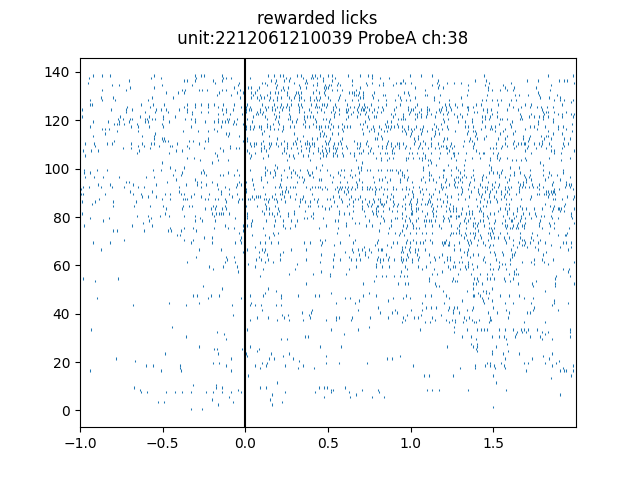

Text(0.5, 0.98, 'rewarded licks \n unit:2212061210039 ProbeA ch:38')

In [147]:
#plot raster colored by trial type
fig,ax=plt.subplots(1,1)
# stim_types=['vis1','vis2','sound1','sound2','catch']

# color_options = ['green','blue','red','orange','grey']

# trial_color_map = {}
# for ii,ss in enumerate(stim_types):
#     trial_color_map[ss]=color_options[ii]

unit_id=good_units.index[20]
# unit_id=20106

for tt in lick_da.licks.values:
    lick_spikes = lick_da.sel(unit_id=unit_id,licks=tt)
#     trial_color=[]
    
#     trial_color = trial_color_map[trials['trialStimID'][tt]]
        
    lick_spike_times = lick_spikes.time[lick_spikes.values.astype('bool')]
    ax.vlines(lick_spike_times,ymin=tt,ymax=tt+1,linewidth=0.75)
    
ax.set_xlim([lick_da.time[0],lick_da.time[-1]])

ax.axvline(0,color='k')
# ax.axvline(0.5,color='k')

fig.suptitle('rewarded licks \n unit:'+str(unit_id)+' Probe'+units['probe'].loc[unit_id]+' ch:'+str(units['peak_channel'].loc[unit_id]))

In [149]:
#free reward trials:
free_rew_trials=trials.query("trialStimID == 'catch' and \
                              trial_rewarded == True")
free_rew_trials

,Unnamed: 0,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_rewarded,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,...,trialOptoDur,trialOptoOnsetFrame,trialOptoVoltage,stimStartTime,stimLatency,trial_stim_dur,first_lick_time,first_lick_latency,first_lick_rw,first_lick_post_rw
56,56,17331,catch,vis1,True,True,0.0,0.0,False,False,...,NaN,NaN,NaN,368.57881,0.0,0.0,369.29864,0.71983,369.29864,370.32608
97,97,30285,catch,vis1,False,True,0.0,0.0,False,False,...,NaN,NaN,NaN,584.00739,0.0,0.0,NaN,NaN,NaN,NaN
158,158,48522,catch,vis1,False,True,0.0,0.0,False,False,...,NaN,NaN,NaN,888.94361,0.0,0.0,NaN,NaN,NaN,NaN
195,195,60986,catch,vis1,False,True,0.0,0.0,False,False,...,NaN,NaN,NaN,1097.24980,0.0,0.0,NaN,NaN,NaN,NaN
277,277,85738,catch,vis1,False,True,0.0,0.0,False,False,...,NaN,NaN,NaN,1512.66134,0.0,0.0,NaN,NaN,NaN,NaN
288,288,89158,catch,vis1,False,True,0.0,0.0,False,False,...,NaN,NaN,NaN,1568.64105,0.0,0.0,NaN,NaN,NaN,NaN
326,326,100357,catch,vis1,False,True,0.0,0.0,False,False,...,NaN,NaN,NaN,1755.81314,0.0,0.0,NaN,NaN,NaN,NaN
350,350,107420,catch,vis1,False,True,0.0,0.0,False,False,...,NaN,NaN,NaN,1874.06121,0.0,0.0,1877.68073,3.61952,NaN,1877.68073
356,356,109383,catch,vis1,False,True,0.0,0.0,False,False,...,NaN,NaN,NaN,1907.20542,0.0,0.0,NaN,NaN,NaN,NaN
386,386,118777,catch,vis1,False,True,0.0,0.0,False,False,...,NaN,NaN,NaN,2064.61944,0.0,0.0,2067.17818,2.55874,NaN,2067.17818


In [150]:
free_rew_lick_df=pd.DataFrame(free_rew_trials['first_lick_post_rw']
                              [~np.isnan(free_rew_trials['first_lick_post_rw'])].values,
                              columns=['start_time'])
free_rew_lick_df

,start_time
0,370.32608
1,1877.68073
2,2067.17818
3,2539.90661
4,2626.57695
5,2727.23810
6,2931.59004
7,3149.54401
8,3185.38535
9,3230.72918


In [151]:
# lick - aligned spikes

#Make tensor
time_before_flash = 1
trial_duration = 3
bin_size = 0.001
free_rew_lick_tensor = make_neuron_time_trials_tensor(good_units, spike_times, free_rew_lick_df, 
                                                      time_before_flash, trial_duration, 
                                                      bin_size)

In [152]:
# make xarray
free_rew_lick_da = xr.DataArray(free_rew_lick_tensor, dims=("unit_id", "time", "licks"), 
                               coords={
                                   "unit_id": good_units.index.values,
                                   "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                                   "licks": np.arange(0,len(free_rew_lick_df))
                                   })

<IPython.core.display.Javascript object>


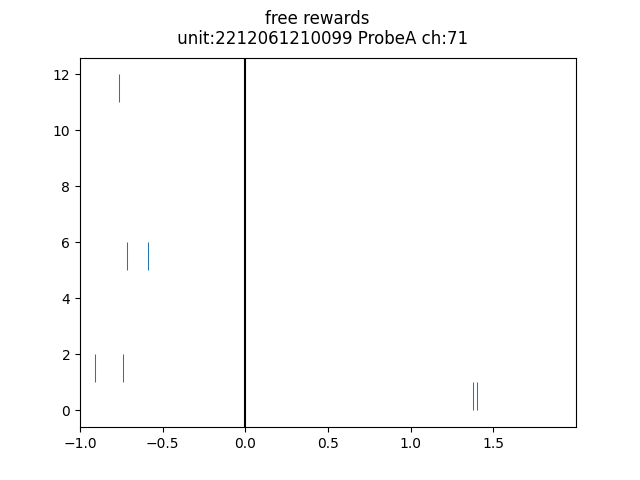

Text(0.5, 0.98, 'free rewards \n unit:2212061210099 ProbeA ch:71')

In [153]:
#plot raster colored by trial type
fig,ax=plt.subplots(1,1)
# stim_types=['vis1','vis2','sound1','sound2','catch']

# color_options = ['green','blue','red','orange','grey']

# trial_color_map = {}
# for ii,ss in enumerate(stim_types):
#     trial_color_map[ss]=color_options[ii]

unit_id=good_units.index[50]
# unit_id=20106

for tt in free_rew_lick_da.licks.values:
    lick_spikes = free_rew_lick_da.sel(unit_id=unit_id,licks=tt)
#     trial_color=[]
    
#     trial_color = trial_color_map[trials['trialStimID'][tt]]
        
    lick_spike_times = lick_spikes.time[lick_spikes.values.astype('bool')]
    ax.vlines(lick_spike_times,ymin=tt,ymax=tt+1,linewidth=0.75)
    
ax.set_xlim([free_rew_lick_da.time[0],free_rew_lick_da.time[-1]])

ax.axvline(0,color='k')
# ax.axvline(0.5,color='k')

fig.suptitle('free rewards \n unit:'+str(unit_id)+' Probe'+units['probe'].loc[unit_id]+
             ' ch:'+str(units['peak_channel'].loc[unit_id]))

In [154]:
omitted_rew_trials = trials.query("trialStimID == trialstimRewarded and \
                                   trial_rewarded == False and \
                                   trial_response == True")
omitted_rew_trials

,Unnamed: 0,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_rewarded,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,...,trialOptoDur,trialOptoOnsetFrame,trialOptoVoltage,stimStartTime,stimLatency,trial_stim_dur,first_lick_time,first_lick_latency,first_lick_rw,first_lick_post_rw
82,82,25598,vis1,vis1,True,False,0.0,0.50,True,False,...,NaN,NaN,NaN,505.748695,0.022885,0.50,506.18657,0.437875,506.18657,506.76569
105,105,32542,vis1,vis1,True,False,0.0,0.50,True,False,...,NaN,NaN,NaN,622.179240,0.023120,0.50,622.63427,0.455030,622.63427,623.26456
209,209,65153,vis1,vis1,True,False,0.0,0.50,True,False,...,NaN,NaN,NaN,1167.030950,0.023100,0.50,1167.53959,0.508640,1167.53959,1168.11683
243,243,75483,vis1,vis1,True,False,0.0,0.75,True,False,...,NaN,NaN,NaN,1339.957550,0.022840,0.75,1340.68359,0.726040,1340.68359,1340.97574
307,307,94749,vis1,vis1,True,False,0.0,0.75,True,False,...,NaN,NaN,NaN,1661.974965,0.023115,0.75,1662.49430,0.519335,1662.49430,1662.99454
365,365,112043,vis1,vis1,True,False,0.0,1.00,True,False,...,NaN,NaN,NaN,1951.681790,0.022820,1.00,1952.06206,0.380270,1952.06206,1952.74832
401,401,123451,vis1,vis1,True,False,0.0,0.50,True,False,...,NaN,NaN,NaN,2143.274455,0.023095,0.50,2144.04293,0.768475,2144.04293,2144.28504
434,434,133609,vis1,vis1,True,False,0.0,0.50,True,False,...,NaN,NaN,NaN,2313.515590,0.022900,0.50,2314.14560,0.630010,2314.14560,2314.80590
486,486,151128,vis1,vis1,True,False,0.0,0.50,True,False,...,NaN,NaN,NaN,2607.643845,0.023065,0.50,2608.13055,0.486705,2608.13055,2608.71992
562,562,176920,vis1,vis1,True,False,0.0,0.50,True,False,...,NaN,NaN,NaN,3039.818600,0.023100,0.50,3040.77215,0.953550,3040.77215,3040.85020


In [155]:
omitted_rew_lick_df=pd.DataFrame(omitted_rew_trials['first_lick_rw']
                                  [~np.isnan(omitted_rew_trials['first_lick_rw'])].values,
                                  columns=['start_time'])
omitted_rew_lick_df

,start_time
0,506.18657
1,622.63427
2,1167.53959
3,1340.68359
4,1662.49430
5,1952.06206
6,2144.04293
7,2314.14560
8,2608.13055
9,3040.77215


In [156]:
# lick - aligned spikes

#Make tensor
time_before_flash = 1
trial_duration = 3
bin_size = 0.001
omitted_rew_lick_tensor = make_neuron_time_trials_tensor(good_units, spike_times, omitted_rew_lick_df, 
                                                      time_before_flash, trial_duration, 
                                                      bin_size)

In [157]:
# make xarray
omitted_rew_lick_da = xr.DataArray(omitted_rew_lick_tensor, dims=("unit_id", "time", "licks"), 
                               coords={
                                   "unit_id": good_units.index.values,
                                   "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                                   "licks": np.arange(0,len(omitted_rew_lick_df))
                                   })

<IPython.core.display.Javascript object>


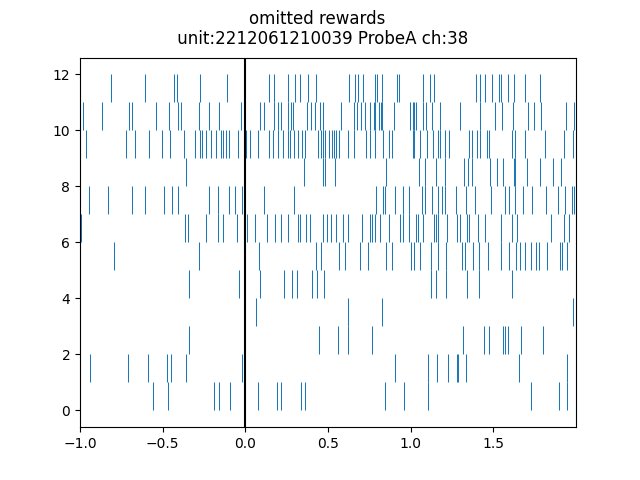

Text(0.5, 0.98, 'omitted rewards \n unit:2212061210039 ProbeA ch:38')

In [158]:
#plot raster colored by trial type
fig,ax=plt.subplots(1,1)
# stim_types=['vis1','vis2','sound1','sound2','catch']

# color_options = ['green','blue','red','orange','grey']

# trial_color_map = {}
# for ii,ss in enumerate(stim_types):
#     trial_color_map[ss]=color_options[ii]

unit_id=good_units.index[20]
# unit_id=20106

for tt in omitted_rew_lick_da.licks.values:
    lick_spikes = omitted_rew_lick_da.sel(unit_id=unit_id,licks=tt)
#     trial_color=[]
    
#     trial_color = trial_color_map[trials['trialStimID'][tt]]
        
    lick_spike_times = lick_spikes.time[lick_spikes.values.astype('bool')]
    ax.vlines(lick_spike_times,ymin=tt,ymax=tt+1,linewidth=0.75)
    
ax.set_xlim([omitted_rew_lick_da.time[0],omitted_rew_lick_da.time[-1]])

ax.axvline(0,color='k')
# ax.axvline(0.5,color='k')

fig.suptitle('omitted rewards \n unit:'+str(unit_id)+' Probe'+units['probe'].loc[unit_id]
             +' ch:'+str(units['peak_channel'].loc[unit_id]))

In [ ]:
### add false alarms to plot below!
# false alarms to different stimuli separately??

<IPython.core.display.Javascript object>


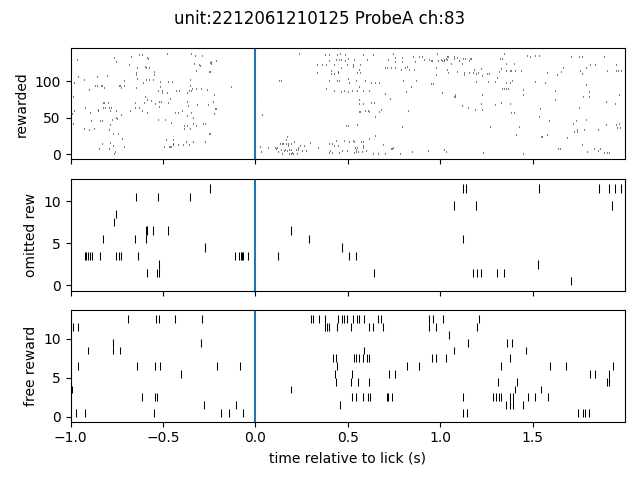

In [167]:
#plot raster colored by trial type
fig,ax=plt.subplots(3,1)

unit_id=good_units.index[65]
# unit_id=20106

# rewarded licks
ax[0].axvline(0)
for tt in lick_da.licks.values:
    lick_spikes = lick_da.sel(unit_id=unit_id,licks=tt)
    lick_spike_times = lick_spikes.time[lick_spikes.values.astype('bool')]
    ax[0].vlines(lick_spike_times,ymin=tt,ymax=tt+1,linewidth=0.75,color='k')
ax[0].set_xlim([lick_da.time[0],lick_da.time[-1]])
ax[0].set_ylabel('rewarded')
ax[0].set_xticklabels([])

# omitted reward licks
ax[1].axvline(0)
for tt in omitted_rew_lick_da.licks.values:
    lick_spikes = omitted_rew_lick_da.sel(unit_id=unit_id,licks=tt)
    lick_spike_times = lick_spikes.time[lick_spikes.values.astype('bool')]
    ax[1].vlines(lick_spike_times,ymin=tt,ymax=tt+1,linewidth=0.75,color='k')
ax[1].set_xlim([omitted_rew_lick_da.time[0],omitted_rew_lick_da.time[-1]])
ax[1].set_ylabel('omitted rew')
ax[1].set_xticklabels([])

# free reward licks
ax[2].axvline(0)
for tt in free_rew_lick_da.licks.values:
    lick_spikes = free_rew_lick_da.sel(unit_id=unit_id,licks=tt)  
    lick_spike_times = lick_spikes.time[lick_spikes.values.astype('bool')]
    ax[2].vlines(lick_spike_times,ymin=tt,ymax=tt+1,linewidth=0.75,color='k')
ax[2].set_xlim([free_rew_lick_da.time[0],free_rew_lick_da.time[-1]])
ax[2].set_ylabel('free reward')
ax[2].set_xlabel('time relative to lick (s)')

fig.suptitle('unit:'+str(unit_id)+' Probe'+units['probe'].loc[unit_id]+' ch:'+str(units['peak_channel'].loc[unit_id]))

fig.tight_layout()

In [160]:
#stim-aligned rewarded vs. omitted trials
#sort by first lick time

time_before_flash = 1
trial_duration = 3
bin_size = 0.001

rewarded_trials = trials.query("trialStimID == trialstimRewarded and \
                                trial_rewarded == True")
rewarded_trials = rewarded_trials.sort_values(by='first_lick_latency')

omitted_rew_trials = trials.query("trialStimID == trialstimRewarded and \
                                   trial_rewarded == False")
omitted_rew_trials = omitted_rew_trials.sort_values(by='first_lick_latency')

rew_stim_tensor = make_neuron_time_trials_tensor(good_units, spike_times, rewarded_trials, 
                                                  time_before_flash, trial_duration, 
                                                  bin_size)
rew_stim_da = xr.DataArray(rew_stim_tensor, dims=("unit_id", "time", "trial"), 
                           coords={
                               "unit_id": good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "trial": rewarded_trials.index.values
                               })


omitted_rew_stim_tensor = make_neuron_time_trials_tensor(good_units, spike_times, omitted_rew_trials, 
                                                          time_before_flash, trial_duration, 
                                                          bin_size)
omitted_rew_stim_da = xr.DataArray(omitted_rew_stim_tensor, dims=("unit_id", "time", "trial"), 
                                   coords={
                                       "unit_id": good_units.index.values,
                                       "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                                       "trial": omitted_rew_trials.index.values
                                       })

<IPython.core.display.Javascript object>


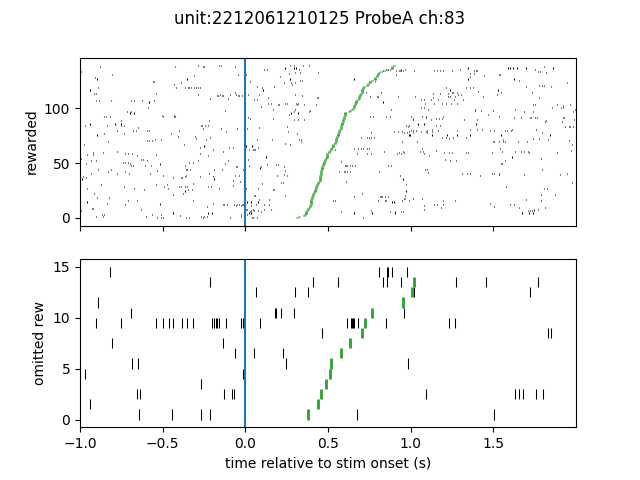

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Text(0.5, 0.98, 'unit:2212061210125 ProbeA ch:83')

In [161]:
#plot raster ordered by time of first lick

fig,ax=plt.subplots(2,1)

unit_id=good_units.index[65]
# unit_id=20106

# rewarded licks
ax[0].axvline(0)
for it,tt in enumerate(rew_stim_da.trial.values):
    trial_spikes = rew_stim_da.sel(unit_id=unit_id,trial=tt)
    trial_spike_times = trial_spikes.time[trial_spikes.values.astype('bool')]
    ax[0].vlines(trial_spike_times,ymin=it,ymax=it+1,linewidth=0.75,color='k')
    ax[0].vlines(trials['first_lick_latency'].loc[tt],ymin=it,ymax=it+1,linewidth=2,color='tab:green')
ax[0].set_xlim([rew_stim_da.time[0],rew_stim_da.time[-1]])
ax[0].set_ylabel('rewarded')
ax[0].set_xticklabels([])

# omitted reward licks
ax[1].axvline(0)
for it,tt in enumerate(omitted_rew_stim_da.trial.values):
    trial_spikes = omitted_rew_stim_da.sel(unit_id=unit_id,trial=tt)
    trial_spike_times = trial_spikes.time[trial_spikes.values.astype('bool')]
    ax[1].vlines(trial_spike_times,ymin=it,ymax=it+1,linewidth=0.75,color='k')
    ax[1].vlines(trials['first_lick_latency'].loc[tt],ymin=it,ymax=it+1,linewidth=2,color='tab:green')
ax[1].set_xlim([omitted_rew_stim_da.time[0],omitted_rew_stim_da.time[-1]])
ax[1].set_ylabel('omitted rew')
ax[1].set_xlabel('time relative to stim onset (s)')

fig.suptitle('unit:'+str(unit_id)+' Probe'+units['probe'].loc[unit_id]
             +' ch:'+str(units['peak_channel'].loc[unit_id]))

<IPython.core.display.Javascript object>


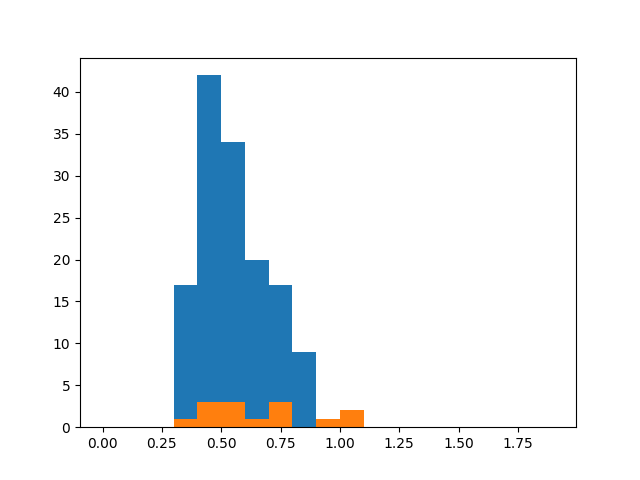

(array([0., 0., 0., 1., 3., 3., 1., 3., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
 <BarContainer object of 19 artists>)

In [162]:
xbins=np.arange(0,2,0.1)

fig,ax=plt.subplots(1,1)
ax.hist(rewarded_trials['first_lick_latency'],bins=xbins)
ax.hist(omitted_rew_trials['first_lick_latency'],bins=xbins)

In [163]:
fa_same_modality_trials = np.zeros((len(trials))).astype(bool)
fa_cross_modality_trials = np.zeros((len(trials))).astype(bool)

for it,tt in trials.iterrows():
    if tt['trial_response']==True:
        if tt['trialStimID']!=tt['trialstimRewarded']:
            if tt['trialStimID'][:-1]==tt['trialstimRewarded'][:-1]:
                fa_same_modality_trials[it]=True
            elif tt['trialStimID']!='catch':
                fa_cross_modality_trials[it]=True

    
    
fa_same_modality_trials = trials.iloc[fa_same_modality_trials]
fa_cross_modality_trials = trials.iloc[fa_cross_modality_trials]

In [215]:
# fa_same_modality_trials

In [164]:
fa_same_lick_df=pd.DataFrame(fa_same_modality_trials['first_lick_rw']
                              [~np.isnan(fa_same_modality_trials['first_lick_rw'])].values,
                              columns=['start_time'])

fa_cross_lick_df=pd.DataFrame(fa_cross_modality_trials['first_lick_rw']
                              [~np.isnan(fa_cross_modality_trials['first_lick_rw'])].values,
                              columns=['start_time'])


In [165]:
time_before_flash = 1
trial_duration = 3
bin_size = 0.001

fa_same_lick_tensor = make_neuron_time_trials_tensor(good_units, spike_times, fa_same_lick_df, 
                                                          time_before_flash, trial_duration, 
                                                          bin_size)

fa_same_lick_da = xr.DataArray(fa_same_lick_tensor, dims=("unit_id", "time", "licks"), 
                           coords={
                               "unit_id": good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "licks": fa_same_lick_df.index.values
                               })

fa_cross_lick_tensor = make_neuron_time_trials_tensor(good_units, spike_times, fa_cross_lick_df, 
                                                          time_before_flash, trial_duration, 
                                                          bin_size)

fa_cross_lick_da = xr.DataArray(fa_cross_lick_tensor, dims=("unit_id", "time", "licks"), 
                           coords={
                               "unit_id": good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "licks": fa_cross_lick_df.index.values
                               })

<IPython.core.display.Javascript object>


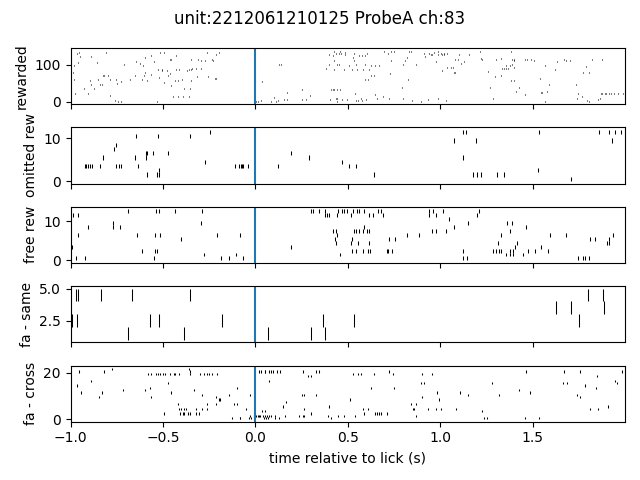

In [166]:
#plot raster colored by trial type
fig,ax=plt.subplots(5,1)

unit_id=good_units.index[65]
# unit_id=60227

# rewarded licks
ax[0].axvline(0)
for tt in lick_da.licks.values:
    lick_spikes = lick_da.sel(unit_id=unit_id,licks=tt)
    lick_spike_times = lick_spikes.time[lick_spikes.values.astype('bool')]
    ax[0].vlines(lick_spike_times,ymin=tt,ymax=tt+1,linewidth=0.75,color='k')
ax[0].set_xlim([lick_da.time[0],lick_da.time[-1]])
ax[0].set_ylabel('rewarded')
ax[0].set_xticklabels([])

# omitted reward licks
ax[1].axvline(0)
for tt in omitted_rew_lick_da.licks.values:
    lick_spikes = omitted_rew_lick_da.sel(unit_id=unit_id,licks=tt)
    lick_spike_times = lick_spikes.time[lick_spikes.values.astype('bool')]
    ax[1].vlines(lick_spike_times,ymin=tt,ymax=tt+1,linewidth=0.75,color='k')
ax[1].set_xlim([omitted_rew_lick_da.time[0],omitted_rew_lick_da.time[-1]])
ax[1].set_ylabel('omitted rew')
ax[1].set_xticklabels([])

# free reward licks
ax[2].axvline(0)
for tt in free_rew_lick_da.licks.values:
    lick_spikes = free_rew_lick_da.sel(unit_id=unit_id,licks=tt)  
    lick_spike_times = lick_spikes.time[lick_spikes.values.astype('bool')]
    ax[2].vlines(lick_spike_times,ymin=tt,ymax=tt+1,linewidth=0.75,color='k')
ax[2].set_xlim([free_rew_lick_da.time[0],free_rew_lick_da.time[-1]])
ax[2].set_ylabel('free rew')
ax[2].set_xticklabels([])

# false alarm - same modality licks
ax[3].axvline(0)
for tt in fa_same_lick_da.licks.values:
    lick_spikes = fa_same_lick_da.sel(unit_id=unit_id,licks=tt)  
    lick_spike_times = lick_spikes.time[lick_spikes.values.astype('bool')]
    ax[3].vlines(lick_spike_times,ymin=tt,ymax=tt+1,linewidth=0.75,color='k')
ax[3].set_xlim([fa_same_lick_da.time[0],fa_same_lick_da.time[-1]])
ax[3].set_ylabel('fa - same')
ax[3].set_xticklabels([])

# false alarm - same modality licks
ax[4].axvline(0)
for tt in fa_cross_lick_da.licks.values:
    lick_spikes = fa_cross_lick_da.sel(unit_id=unit_id,licks=tt)  
    lick_spike_times = lick_spikes.time[lick_spikes.values.astype('bool')]
    ax[4].vlines(lick_spike_times,ymin=tt,ymax=tt+1,linewidth=0.75,color='k')
ax[4].set_xlim([fa_cross_lick_da.time[0],fa_cross_lick_da.time[-1]])
ax[4].set_ylabel('fa - cross')
ax[4].set_xlabel('time relative to lick (s)')

fig.suptitle('unit:'+str(unit_id)+' Probe'+units['probe'].loc[unit_id]+' ch:'+str(units['peak_channel'].loc[unit_id]))

fig.tight_layout()